# Plot the stats results from dtu 10MW and our design

Jupyter notebook made from Jenni's plot_steady.py

In [1]:
# -*- coding: utf-8 -*-
"""Compare mean value of steady simulations in HAWC2 (blue dots) to "theory" (lines).

For the operational parameters (i.e., pitch, rotor speed, etc.), the "theoretical" values
are the corresponding values in a .pwr file.

For the load channels of interest, the theoretical lines are calculated according to the
theoretical equations we derived for each load channel, as a function of thrust/torque/
gravity moment.

YOUR TASK! Add the lines that calculate the theory, as prompted by the slides.
"""
from lacbox.io import load_stats, load_oper
import matplotlib.pyplot as plt
import numpy as np
import pathlib
from pathlib import Path

# DTU 10MW

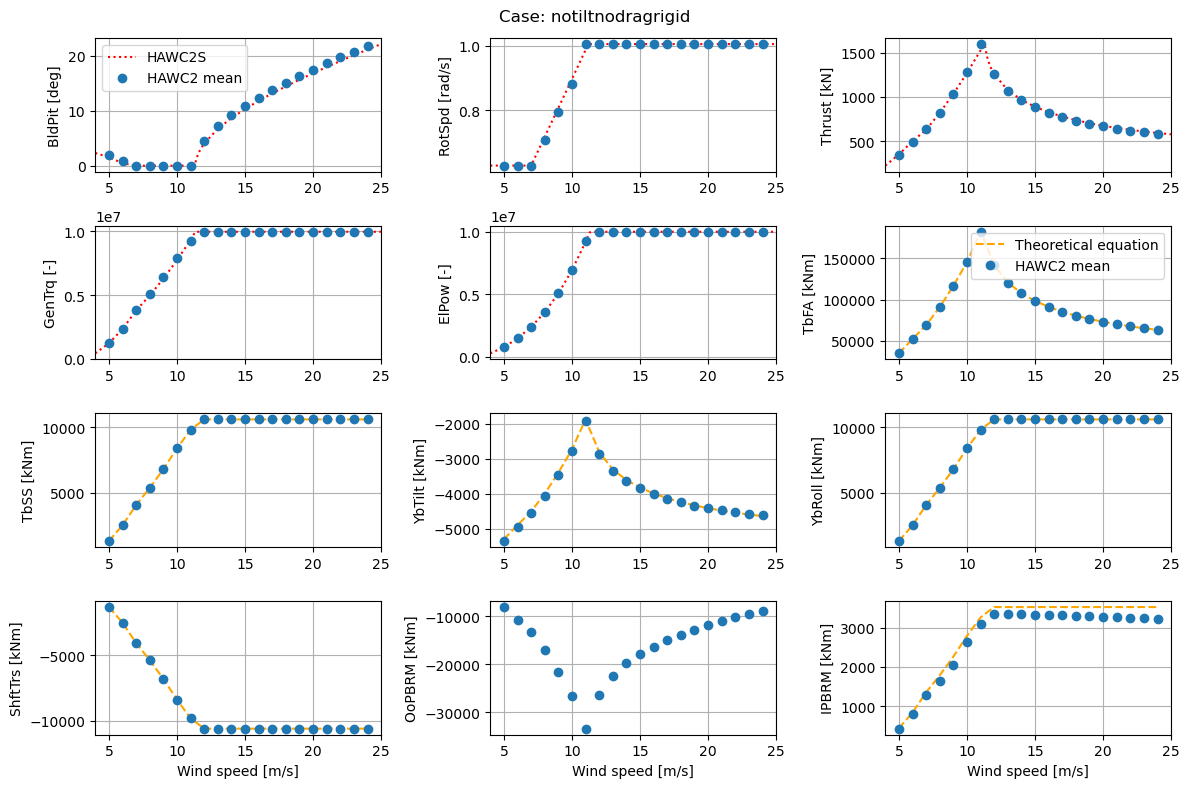

In [5]:
# analysis settings
HAWC2S_PATH = Path.cwd().parent / 'dtu_10MW/steady/dtu_10mw_res/dtu_10mw_flex_minrotspd.opt'  # path to .pwr or .opt file
STATS_PATH = Path.cwd().parent / 'dtu_10MW/steady/dtu_10mw_res/dtu_10mw_steady_stats.hdf5'  # path to mean steady stats
SUBFOLDER = 'notiltnodragrigid'  # which subfolder to plot: tilt, notilt, notiltrigid, notiltnodragrigid

# turbine constants
GENEFF = 0.94  # generator/gearbox efficienty [%]
FG_TIMES_DY = 6250  # yaw-bearing pitch moment due to gravity [kNm]
if 'notilt' in SUBFOLDER:
    DZ_YB = 2.75  # distance from hub center to yaw bearing [m]
    DZ_TB = 115.63 + DZ_YB  # distance from hub center to tower base [m]
else:
    DZ_YB = 2.75 + 7.1*np.sin(5*np.pi/180)  # distance from hub center to yaw bearing [m]
    DZ_TB = 115.63 + DZ_YB  # distance from hub center to tower base [m]
CHAN_DESCS = {'BldPit': 'pitch1 angle',  # dictionary used to identify which descriptions
              'RotSpd': 'rotor speed',  # in the HAWC2 statistics file correspond to which
              'Thrust': 'aero rotor thrust',  # channels we want
              'GenTrq': 'generator torque',
              'ElPow': 'pelec',
              'TbFA': 'momentmx mbdy:tower nodenr:   1',
              'TbSS': 'momentmy mbdy:tower nodenr:   1',
              'YbTilt': 'momentmx mbdy:tower nodenr:  11',
              'YbRoll': 'momentmy mbdy:tower nodenr:  11',
              'ShftTrs': 'momentmz mbdy:shaft nodenr:   4',
              'OoPBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: hub1',
              'IPBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: hub1',
              'FlpBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: blade1',
              'EdgBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: blade1',
              'OoPHub': 'momentmx mbdy:hub1 nodenr:   1 coo: hub1',
              'IPHub': 'momentmy mbdy:hub1 nodenr:   1 coo: hub1',
              }

# what channels we want to plot
chan_ids = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow', 'TbFA', 'TbSS',
            'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

# load the HAWC2 data from the stats file. Isolate the simulations with no tilt.
df, wsps = load_stats(STATS_PATH, subfolder=SUBFOLDER, statstype='steady')

# load/calc. the stuff we need from the HAWC2S opt/pwr file for the operational data comparisons
opt_dict = load_oper(HAWC2S_PATH)
h2s_u, h2s_pitch, h2s_rotspd, = opt_dict['ws_ms'], opt_dict['pitch_deg'], opt_dict['rotor_speed_rpm']
h2s_paero, h2s_thrust = opt_dict['power_kw'], opt_dict['thrust_kn']
h2s_aerotrq = h2s_paero / (h2s_rotspd * np.pi / 30)

# get hawc2 thrust and aerodynamic torque for theoretical calculations
h2_thrust = df.filter_channel('Thrust', CHAN_DESCS)['mean']
h2_aero_trq = df.filter_channel('GenTrq', CHAN_DESCS)['mean'] / GENEFF * 1e-3  # aerodynamic torque [kNm]

# initialize the figure and axes
fig, axs = plt.subplots(4, 3, figsize=(12, 8), clear=True)

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):
    
    # isolate the channel data
    chan_df = df.filter_channel(chan_id, CHAN_DESCS)

    # extract hawc2 wind and channel to plot from the HAWC2 stats
    h2_wind = chan_df['wsp']
    HAWC2val = chan_df['mean']

    match chan_id:
        # ===========================================================================
        # PART 1. HAWC2 operational data versus HAWC2S opt file.
        case 'BldPit':  # pitch angle
            u_theory = h2s_u
            theory = h2s_pitch
        case 'RotSpd':  # rotor speed
            u_theory = h2s_u
            theory = h2s_rotspd * np.pi /30  # TODO: update line!
        case 'Thrust':  # thrust
            u_theory = h2s_u
            theory = h2s_thrust  # TODO: update line!
        case 'GenTrq': # generator torque
            u_theory = h2s_u
            theory = h2s_aerotrq * GENEFF * 10**3 # TODO: update line!
        case 'ElPow':  # electrical power
            u_theory = h2s_u
            theory = h2s_paero * GENEFF * 10**3  # TODO: update line!

        # ===========================================================================
        # PART 2. HAWC2 loads versus theory calculated using HAWC2 thrust/torque.
        case 'TbFA':  # tower-base fore-aft
            u_theory = h2_wind
            theory = h2_thrust * DZ_TB - FG_TIMES_DY
        case 'TbSS':  # tower-base side-side
            u_theory = h2_wind
            theory = h2_aero_trq  # TODO: update line!
        case 'YbTilt':  # yaw bearing tilt
            u_theory = h2_wind
            theory = h2_thrust*  DZ_YB - FG_TIMES_DY # TODO: update line!
        case 'YbRoll':  # yaw bearing roll
            u_theory = h2_wind
            theory = h2_aero_trq  # TODO: update line!
        case 'ShftTrs':  # shaft torsion
            u_theory = h2_wind
            theory = -h2_aero_trq  # TODO: update line!
        case 'IPBRM':
            u_theory = h2_wind
            theory = h2_aero_trq/3
        # case 'OopBRM':
        #     u_theory = h2_wind
        #     theory = 

        # other values have no theory
        case other:
            u_theory = h2_wind
            theory = np.nan * np.ones_like(u_theory)

    # sort both the theory and the hawc2 by increasing wind speed (convert to numpy arrays first)
    u_theory, theory = np.array(u_theory), np.array(theory)
    h2_wind, HAWC2val = np.array(h2_wind), np.array(HAWC2val)
    i_theory = np.argsort(u_theory)
    i_h2 = np.argsort(h2_wind)

    # define legend label for the "theoretical" line
    if np.nan in theory:
        theory_label = None
    elif np.array_equal(u_theory, h2s_u):
        theory_label = 'HAWC2S'
        linestyle, color = ':', 'r'
    else:
        theory_label = 'Theoretical equation'
        linestyle, color = '--', '#ffa500'

    # plot the results
    ax = axs.flatten()[iplot]
    ax.plot(u_theory[i_theory], theory[i_theory], linestyle=linestyle, c=color, label=theory_label)  # theoretical line
    ax.plot(h2_wind[i_h2], HAWC2val[i_h2], 'o', label='HAWC2 mean')  # HAWC2 steady results
    ax.grid('on')
    ax.set(xlabel='Wind speed [m/s]' if iplot > 8 else None,
           ylabel=f'{chan_id} [{chan_df.units.iloc[0]}]', xlim=[4, 25])

axs[0, 0].legend()
axs[1, 2].legend()
fig.suptitle(f'Case: {SUBFOLDER}')
fig.tight_layout()

plt.show()

# Our Design

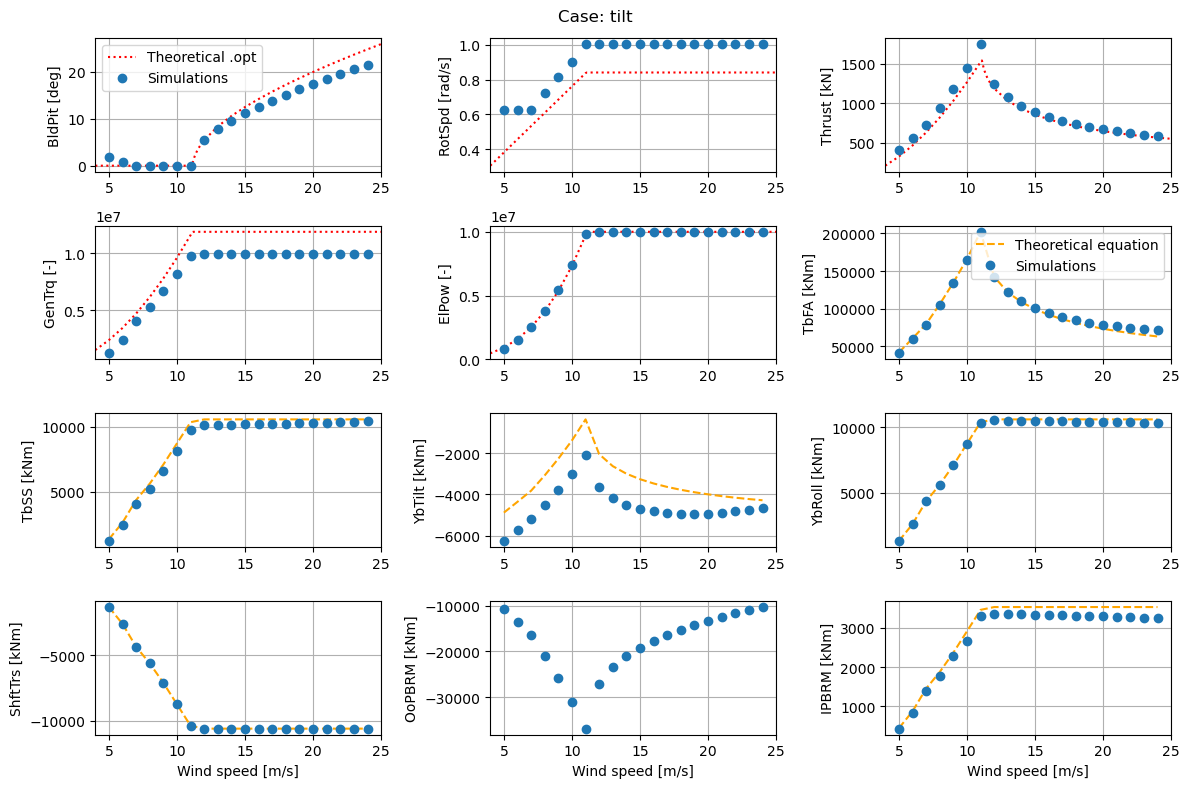

In [ ]:
# analysis settings
HAWC2S_PATH = Path.cwd().parent / 'our_design/data/BB_redesign_compute_flex_opt.opt'  # path to .pwr or .opt file
STATS_PATH = Path.cwd().parent / 'our_design/steady/res_steady/BB_10mw_steady_stats.csv'  # path to mean steady stats
SUBFOLDER = 'tilt'  # which subfolder to plot: tilt, notilt, notiltrigid, notiltnodragrigid

# turbine constants
GENEFF = 0.94  # generator/gearbox efficienty [%]
FG_TIMES_DY = 6250  # yaw-bearing pitch moment due to gravity [kNm]
if 'notilt' in SUBFOLDER:
    DZ_YB = 2.75  # distance from hub center to yaw bearing [m]
    DZ_TB = 115.63 + DZ_YB  # distance from hub center to tower base [m]
else:
    DZ_YB = 2.75 + 7.1*np.sin(5*np.pi/180)  # distance from hub center to yaw bearing [m]
    DZ_TB = 115.63 + DZ_YB  # distance from hub center to tower base [m]
CHAN_DESCS = {'BldPit': 'pitch1 angle',  # dictionary used to identify which descriptions
              'RotSpd': 'rotor speed',  # in the HAWC2 statistics file correspond to which
              'Thrust': 'aero rotor thrust',  # channels we want
              'GenTrq': 'generator torque',
              'ElPow': 'pelec',
              'TbFA': 'momentmx mbdy:tower nodenr:   1',
              'TbSS': 'momentmy mbdy:tower nodenr:   1',
              'YbTilt': 'momentmx mbdy:tower nodenr:  11',
              'YbRoll': 'momentmy mbdy:tower nodenr:  11',
              'ShftTrs': 'momentmz mbdy:shaft nodenr:   4',
              'OoPBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: hub1',
              'IPBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: hub1',
              'FlpBRM': 'momentmx mbdy:blade1 nodenr:   1 coo: blade1',
              'EdgBRM': 'momentmy mbdy:blade1 nodenr:   1 coo: blade1',
              'OoPHub': 'momentmx mbdy:hub1 nodenr:   1 coo: hub1',
              'IPHub': 'momentmy mbdy:hub1 nodenr:   1 coo: hub1',
              }

# what channels we want to plot
chan_ids = ['BldPit', 'RotSpd', 'Thrust', 'GenTrq', 'ElPow', 'TbFA', 'TbSS',
            'YbTilt', 'YbRoll', 'ShftTrs', 'OoPBRM', 'IPBRM']

# load the HAWC2 data from the stats file. Isolate the simulations with no tilt.
df, wsps = load_stats(STATS_PATH, subfolder=SUBFOLDER, statstype='steady')

# load/calc. the stuff we need from the HAWC2S opt/pwr file for the operational data comparisons
opt_dict = load_oper(HAWC2S_PATH)
h2s_u, h2s_pitch, h2s_rotspd, = opt_dict['ws_ms'], opt_dict['pitch_deg'], opt_dict['rotor_speed_rpm']
h2s_paero, h2s_thrust = opt_dict['power_kw'], opt_dict['thrust_kn']
h2s_aerotrq = h2s_paero / (h2s_rotspd * np.pi / 30)

# get hawc2 thrust and aerodynamic torque for theoretical calculations
h2_thrust = df.filter_channel('Thrust', CHAN_DESCS)['mean']
h2_aero_trq = df.filter_channel('GenTrq', CHAN_DESCS)['mean'] / GENEFF * 1e-3  # aerodynamic torque [kNm]

# initialize the figure and axes
fig, axs = plt.subplots(4, 3, figsize=(12, 8), clear=True)

# loop over each channels and plot the steady state with the theory line
for iplot, chan_id in enumerate(chan_ids):
    
    # isolate the channel data
    chan_df = df.filter_channel(chan_id, CHAN_DESCS)

    # extract hawc2 wind and channel to plot from the HAWC2 stats
    h2_wind = chan_df['wsp']
    HAWC2val = chan_df['mean']

    match chan_id:
        # ===========================================================================
        # PART 1. HAWC2 operational data versus HAWC2S opt file.
        case 'BldPit':  # pitch angle
            u_theory = h2s_u
            theory = h2s_pitch
        case 'RotSpd':  # rotor speed
            u_theory = h2s_u
            theory = h2s_rotspd * np.pi /30  
        case 'Thrust':  # thrust
            u_theory = h2s_u
            theory = h2s_thrust  
        case 'GenTrq': # generator torque
            u_theory = h2s_u
            theory = h2s_aerotrq * GENEFF * 10**3 
        case 'ElPow':  # electrical power
            u_theory = h2s_u
            theory = h2s_paero * GENEFF * 10**3  

        # ===========================================================================
        # PART 2. HAWC2 loads versus theory calculated using HAWC2 thrust/torque.
        case 'TbFA':  # tower-base fore-aft
            u_theory = h2_wind
            theory = h2_thrust * DZ_TB - FG_TIMES_DY
        case 'TbSS':  # tower-base side-side
            u_theory = h2_wind
            theory = h2_aero_trq  
        case 'YbTilt':  # yaw bearing tilt
            u_theory = h2_wind
            theory = h2_thrust*  DZ_YB - FG_TIMES_DY 
        case 'YbRoll':  # yaw bearing roll
            u_theory = h2_wind
            theory = h2_aero_trq  
        case 'ShftTrs':  # shaft torsion
            u_theory = h2_wind
            theory = -h2_aero_trq  
        case 'IPBRM':
            u_theory = h2_wind
            theory = h2_aero_trq/3
        # case 'OopBRM':
        #     u_theory = h2_wind
        #     theory = 

        # other values have no theory
        case other:
            u_theory = h2_wind
            theory = np.nan * np.ones_like(u_theory)

    # sort both the theory and the hawc2 by increasing wind speed (convert to numpy arrays first)
    u_theory, theory = np.array(u_theory), np.array(theory)
    h2_wind, HAWC2val = np.array(h2_wind), np.array(HAWC2val)
    i_theory = np.argsort(u_theory)
    i_h2 = np.argsort(h2_wind)

    # define legend label for the "theoretical" line
    if np.nan in theory:
        theory_label = None
    elif np.array_equal(u_theory, h2s_u):
        theory_label = 'Theoretical .opt'
        linestyle, color = ':', 'r'
    else:
        theory_label = 'Theoretical equation'
        linestyle, color = '--', '#ffa500'

    # plot the results
    ax = axs.flatten()[iplot]
    ax.plot(u_theory[i_theory], theory[i_theory], linestyle=linestyle, c=color, label=theory_label)  # theoretical line
    ax.plot(h2_wind[i_h2], HAWC2val[i_h2], 'o', label='Simulations')  # HAWC2 steady results
    ax.grid('on')
    ax.set(xlabel='Wind speed [m/s]' if iplot > 8 else None,
           ylabel=f'{chan_id} [{chan_df.units.iloc[0]}]', xlim=[4, 25])

axs[0, 0].legend()
axs[1, 2].legend()
fig.suptitle(f'Case: {SUBFOLDER}')
fig.tight_layout()

# plt.savefig('Plots/steady_simulations_tilt_our_design.png', dpi=300)
plt.show()

